# Bitcoin Price Prediction - Documentation
## BS Data Science Project - Recurrent Bitcoin Network

This notebook contains a brief documentation on retrieving data from [Messari](https://messari.io/) through its web [API](https://messari.io/api/docs).

### Prerequesites

Before running this notebook, several python packages are needed to be installed as shown in the following cell. In addition, changing of working directory within the local repository was done.

### License

This notebook is licensed under GNU General Public License v3.0. See `LICENSE` in the project root for details.

In [1]:
# Built-in packages
import os
from datetime import datetime

In [2]:
os.chdir('../src')

In [3]:
# Packages to be installed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

# Local python functions
import collect
import pipeline

In [4]:
%load_ext tensorboard

In [5]:
# Notebook Execution Time
print('Current time: {}'.format(datetime.now()))

Current time: 2022-03-22 13:39:05.713815


In [6]:
# Use this cell if you intend to apply your Messari API key
# os.environ['MESSARI_API_KEY'] = <insert_key_here>

In [7]:
'MESSARI_API_KEY' in os.environ

True

In [8]:
collector = collect.MessariCollector(api_key=os.getenv('MESSARI_API_KEY'))

### Data
The expected data would be a data frame of time series data denoted by its columns and it would be splitted, normalized, and be fed for model training and testing. In this project, we would only use daily time series data from 2016 to 2020 as the training set, while 2021 data would be used as a test set.

The following table below shows a sample of metrics to be used as features for Bitcoin price forecasting, along with their descriptions and sources. For full list of metrics, see `metrics.csv`.

In [9]:
df_metrics = collector.get_metrics()
df_metrics.data.to_csv('../raw/metrics.csv')
df_metrics.data

,name,description,minimum_interval,role_restriction,source_name,source_url
metric_id,,,,,,
act.addr.cnt,Active Addresses Count,The sum count of unique addresses that were ac...,1d,NaN,Coinmetrics,https://coinmetrics.io
addr.act.rcv.cnt,Active Addresses Count (Received),The sum count of unique addresses that were ac...,1d,"[pro, enterprise]",Coinmetrics,https://coinmetrics.io
addr.act.sent.cnt,Active Addresses Count (Sent),The sum count of unique addresses that were ac...,1d,"[pro, enterprise]",Coinmetrics,https://coinmetrics.io
addr.bal.0.001.ntv.cnt,Addresses with balance greater than 0.001 nati...,The sum count of unique addresses holding at l...,1d,"[pro, enterprise]",Coinmetrics,https://coinmetrics.io
addr.bal.0.01.ntv.cnt,Addresses with balance greater than 0.01 nativ...,The sum count of unique addresses holding at l...,1d,"[pro, enterprise]",Coinmetrics,https://coinmetrics.io
...,...,...,...,...,...,...
utxo.age.med,Median UTXO Age,The median age in full days of all unspent tra...,1d,"[pro, enterprise]",Coinmetrics,https://coinmetrics.io
utxo.age.val.avg,Value-weighted Average UTXO Age,The value-weighted average age in full days of...,1d,"[pro, enterprise]",Coinmetrics,https://coinmetrics.io
utxo.cnt,UTXO Count,The sum count of unspent transaction outputs t...,1d,"[pro, enterprise]",Coinmetrics,https://coinmetrics.io


In [10]:
btc_metrics = df_metrics.data.copy()
btc_metrics = btc_metrics[btc_metrics['role_restriction'].isna()]

In [11]:
selected_metrics = [
    'act.addr.cnt', 'blk.cnt', 'blk.size.byte', 'daily.shp', 'daily.vol',
    'diff.avg', 'exch.flow.in.ntv.incl', 'exch.flow.out.ntv.incl', 'fees.ntv',
    'hashrate', 'nvt.adj.90d.ma', 'price', 'sply.total.iss.ntv', 'txn.cnt',
    'txn.tfr.val.adj.ntv', 'txn.tfr.val.med.ntv', 'txn.tsfr.cnt',
]

In [12]:
# btc_metrics.drop(metrics_to_remove, inplace=True)
btc_metrics = btc_metrics.loc[selected_metrics]

In [13]:
btc_metrics.to_csv('../raw/bitcoin_metrics.csv')

In [14]:
print(f'Number of metrics: {btc_metrics.shape[0]}')
btc_metrics

Number of metrics: 17


,name,description,minimum_interval,role_restriction,source_name,source_url
metric_id,,,,,,
act.addr.cnt,Active Addresses Count,The sum count of unique addresses that were ac...,1d,NaN,Coinmetrics,https://coinmetrics.io
blk.cnt,Block Count,The sum count of blocks created each day,1d,NaN,Coinmetrics,https://coinmetrics.io
blk.size.byte,Block Size (bytes),The sum of the size (in bytes) of all blocks c...,1d,NaN,Coinmetrics,https://coinmetrics.io
daily.shp,Sharpe Ratio,The Sharpe ratio (performance of the asset com...,1d,NaN,Kaiko,https://www.kaiko.com/
daily.vol,Volatility,The annualized standard-deviation of daily ret...,1d,NaN,Kaiko,https://www.kaiko.com/
diff.avg,Average Difficulty,The mean difficulty of finding a hash that mee...,1d,NaN,Coinmetrics,https://coinmetrics.io
exch.flow.in.ntv.incl,Deposits on Exchanges - Inclusive (Native Units),The amount of the asset sent to exchanges that...,1d,NaN,Coinmetrics,https://coinmetrics.io
exch.flow.out.ntv.incl,Withdrawals from Exchanges - Inclusive (Native...,The amount of the asset withdrawn from exchang...,1d,NaN,Coinmetrics,https://coinmetrics.io
fees.ntv,Total Fees (Native Units),The sum of all fees paid to miners in native u...,1d,NaN,Coinmetrics,https://coinmetrics.io


In [15]:
# Data Sources
btc_metrics['source_name'].unique()

array(['Coinmetrics', 'Kaiko'], dtype=object)

### Retrieve Time Series Data

In this section, we would retrieve time series data with the given metrics retrieved above. A script was implemented to automate the data collection process.

In [16]:
try:
    train_df = pd.read_csv('../raw/train.csv', parse_dates=['timestamp'])
except FileNotFoundError:
    if not os.path.exists('../raw'):
        os.mkdir('../raw')

    train_raw = collector.get_batch_data(
        assetkey='BTC',
        metrics=btc_metrics.index,
        start='2016-01-01',
        end='2020-12-31'
    )
    train_df = pd.concat(
        [resp.get_melt_data() for resp in train_raw],
        ignore_index=True
    )
    train_df.to_csv('../raw/train.csv', index=False)

In [17]:
try:
    test_df = pd.read_csv('../raw/test.csv', parse_dates=['timestamp'])
except FileNotFoundError:
    if not os.path.exists('../raw'):
        os.mkdir('../raw')

    test_raw = collector.get_batch_data(
        assetkey='BTC',
        metrics=btc_metrics.index,
        start='2021-01-01',
        end='2021-06-30'
    )
    test_df = pd.concat(
        [resp.get_melt_data() for resp in test_raw],
        ignore_index=True
    )
    test_df.to_csv('../raw/test.csv', index=False)

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49329 entries, 0 to 49328
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  49329 non-null  datetime64[ns]
 1   metric     49329 non-null  object        
 2   submetric  49329 non-null  object        
 3   value      49329 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 1.5+ MB


In [19]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4887 entries, 0 to 4886
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  4887 non-null   datetime64[ns]
 1   metric     4887 non-null   object        
 2   submetric  4887 non-null   object        
 3   value      4887 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 152.8+ KB


### Data Transformation

We would convert the given time series data from a long format to a wide format.

In [20]:
wide_train = train_df.pivot_table(
    index='timestamp',
    columns=['metric', 'submetric'],
    values='value'
)

prices_train = wide_train.pop('price')

In [21]:
wide_test = test_df.pivot_table(
    index='timestamp',
    columns=['metric', 'submetric'],
    values='value'
)

prices_test = wide_test.pop('price')

In [22]:
wide_train.head()

metric         act.addr.cnt     blk.cnt blk.size.byte  daily.shp             \
submetric  active_addresses block_count   block_count sharpe_1yr sharpe_30d   
timestamp                                                                     
2016-01-01         316781.0       135.0    66544854.0   0.869196   3.254284   
2016-01-02         417966.0       145.0    83567789.0   0.903431   3.742549   
2016-01-03         398443.0       145.0    82041255.0   0.885630   3.463730   
2016-01-04         413159.0       181.0    99672880.0   1.075561   3.520499   
2016-01-05         435291.0       157.0   100644706.0   1.157387   2.312140   

metric                                daily.vol                                \
submetric  sharpe_3yr sharpe_90d volatility_1yr volatility_30d volatility_3yr   
timestamp                                                                       
2016-01-01   1.604864   3.685772       0.685757       0.640308       1.028978   
2016-01-02   1.609291   3.635713       0.685251       0.631588       1.028922   
2016-01-03   1.612791   3.592289       0.685339       0.633846       1.028857   
2016-01-04   1.612907   3.596404       0.675956       0.633926       1.028857   
2016-01-05   1.609834   3.442895       0.673562       0.592641       1.028863   

metric      ... exch.flow.in.ntv.incl exch.flow.out.ntv.incl   fees.ntv  \
submetric   ...               flow_in               flow_out fees_total   
timestamp   ...                                                           
2016-01-01  ...          32181.171652           32140.264148  19.872695   
2016-01-02  ...          26274.545676           25734.048833  31.235525   
2016-01-03  ...          39479.215335           31982.605215  24.473062   
2016-01-04  ...          45876.869599           47624.251920  30.382633   
2016-01-05  ...          51377.988662           67452.426637  32.511258   

metric           hashrate      nvt.adj.90d.ma sply.total.iss.ntv  \
submetric       hash_rate nvt_adjusted_90d_ma     issuance_total   
timestamp                                                          
2016-01-01  697129.166406           41.147256             3375.0   
2016-01-02  748768.363917           41.048731             3625.0   
2016-01-03  748768.363917           40.644184             3625.0   
2016-01-04  934669.474959           40.918827             4525.0   
2016-01-05  810735.400931           40.754906             3925.0   

metric               txn.cnt         txn.tfr.val.adj.ntv  \
submetric  transaction_count transaction_volume_adjusted   
timestamp                                                  
2016-01-01          124427.0               174515.818449   
2016-01-02          147864.0               189629.972730   
2016-01-03          145029.0               232482.193500   
2016-01-04          178576.0               258630.297507   
2016-01-05          183659.0               335747.819336   

metric       txn.tfr.val.med.ntv    txn.tsfr.cnt  
submetric  transfer_value_median transfers_count  
timestamp                                         
2016-01-01              0.011701        320580.0  
2016-01-02              0.006900        405602.0  
2016-01-03              0.005126        432531.0  
2016-01-04              0.017405        419538.0  
2016-01-05              0.019620        438135.0  

[5 rows x 22 columns]

In [23]:
wide_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2016-01-01 to 2020-12-31
Data columns (total 22 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   (act.addr.cnt, active_addresses)                    1827 non-null   float64
 1   (blk.cnt, block_count)                              1827 non-null   float64
 2   (blk.size.byte, block_count)                        1827 non-null   float64
 3   (daily.shp, sharpe_1yr)                             1827 non-null   float64
 4   (daily.shp, sharpe_30d)                             1827 non-null   float64
 5   (daily.shp, sharpe_3yr)                             1827 non-null   float64
 6   (daily.shp, sharpe_90d)                             1827 non-null   float64
 7   (daily.vol, volatility_1yr)                         1827 non-null   float64
 8   (daily.vol, volatility_30d)                         1827 non

In [24]:
prices_train.head()

submetric,close,high,low,open,volume
timestamp,,,,,
2016-01-01,433.960345,437.841344,426.068766,430.206620,2.099646e+07
2016-01-02,433.221343,436.820867,431.542401,434.015456,1.393225e+07
2016-01-03,429.132867,433.727409,422.757469,433.212063,2.396948e+07
2016-01-04,433.152291,435.231337,428.233668,429.401480,2.528594e+07
2016-01-05,432.001391,434.548442,428.386082,432.978697,1.956450e+07


In [25]:
wide_test.head()

metric         act.addr.cnt     blk.cnt blk.size.byte  daily.shp             \
submetric  active_addresses block_count   block_count sharpe_1yr sharpe_30d   
timestamp                                                                     
2021-01-01        1001890.0       149.0   200183875.0   2.155131   8.298569   
2021-01-02        1140633.0       151.0   210941948.0   2.227206   9.182984   
2021-01-03        1184688.0       158.0   202984712.0   2.227079  10.845058   
2021-01-04        1270082.0       173.0   228206364.0   2.147672   8.671640   
2021-01-05        1230529.0       157.0   202837860.0   2.147846   9.762872   

metric                                daily.vol                                \
submetric  sharpe_3yr sharpe_90d volatility_1yr volatility_30d volatility_3yr   
timestamp                                                                       
2021-01-01   0.348882   7.383160       0.753934       0.631271       0.762070   
2021-01-02   0.393070   7.684719       0.760788       0.725350       0.765063   
2021-01-03   0.389926   7.769999       0.757727       0.657062       0.764035   
2021-01-04   0.316454   7.363521       0.760406       0.708616       0.761901   
2021-01-05   0.331617   7.770842       0.756858       0.676053       0.761347   

metric      ... exch.flow.in.ntv.incl exch.flow.out.ntv.incl    fees.ntv  \
submetric   ...               flow_in               flow_out  fees_total   
timestamp   ...                                                            
2021-01-01  ...          30826.225651           30543.241817   48.651326   
2021-01-02  ...          56011.060538           51989.534408   81.970521   
2021-01-03  ...          54049.006966           40161.077793   85.005302   
2021-01-04  ...          69415.967283           66213.830899  109.547478   
2021-01-05  ...          46239.330512           50679.887274  114.155450   

metric          hashrate      nvt.adj.90d.ma sply.total.iss.ntv  \
submetric      hash_rate nvt_adjusted_90d_ma     issuance_total   
timestamp                                                         
2021-01-01  1.377640e+08          117.977582             931.25   
2021-01-02  1.396132e+08          125.420388             943.75   
2021-01-03  1.460853e+08          128.553868             987.50   
2021-01-04  1.599542e+08          120.732416            1081.25   
2021-01-05  1.451608e+08          127.138194             981.25   

metric               txn.cnt         txn.tfr.val.adj.ntv  \
submetric  transaction_count transaction_volume_adjusted   
timestamp                                                  
2021-01-01          261318.0               246500.650497   
2021-01-02          297595.0               371861.434554   
2021-01-03          359641.0               250591.111935   
2021-01-04          370865.0               319640.613698   
2021-01-05          355008.0               295151.678093   

metric       txn.tfr.val.med.ntv    txn.tsfr.cnt  
submetric  transfer_value_median transfers_count  
timestamp                                         
2021-01-01              0.004028        745255.0  
2021-01-02              0.005183        846740.0  
2021-01-03              0.004561        957490.0  
2021-01-04              0.005741       1009564.0  
2021-01-05              0.005333       1005028.0  

[5 rows x 22 columns]

In [26]:
wide_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 181 entries, 2021-01-01 to 2021-06-30
Data columns (total 22 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   (act.addr.cnt, active_addresses)                    181 non-null    float64
 1   (blk.cnt, block_count)                              181 non-null    float64
 2   (blk.size.byte, block_count)                        181 non-null    float64
 3   (daily.shp, sharpe_1yr)                             181 non-null    float64
 4   (daily.shp, sharpe_30d)                             181 non-null    float64
 5   (daily.shp, sharpe_3yr)                             181 non-null    float64
 6   (daily.shp, sharpe_90d)                             181 non-null    float64
 7   (daily.vol, volatility_1yr)                         181 non-null    float64
 8   (daily.vol, volatility_30d)                         181 non-n

In [27]:
prices_test.head()

submetric,close,high,low,open,volume
timestamp,,,,,
2021-01-01,29402.176951,29674.366390,28692.320100,28963.116282,5.206879e+09
2021-01-02,32200.200909,33268.527789,29022.584583,29394.914671,1.150113e+10
2021-01-03,33061.908711,34810.548275,31984.603073,32209.643507,1.151527e+10
2021-01-04,32013.657608,33686.591916,27902.210046,32979.561700,1.317324e+10
2021-01-05,34033.028441,34495.109124,29915.527058,31983.572856,1.084223e+10


### Exploratory Data Analysis

In [28]:
wide_train.describe()

metric        act.addr.cnt      blk.cnt blk.size.byte    daily.shp  \
submetric active_addresses  block_count   block_count   sharpe_1yr   
count         1.827000e+03  1827.000000  1.827000e+03  1827.000000   
mean          7.097668e+05   149.278051  1.447808e+08     1.239195   
std           1.763584e+05    16.075478  2.893240e+07     1.156953   
min           3.167810e+05    80.000000  6.654485e+07    -1.925901   
25%           5.829215e+05   139.000000  1.223714e+08     0.568562   
50%           6.896430e+05   149.000000  1.437433e+08     1.336053   
75%           8.130080e+05   160.000000  1.639708e+08     2.018859   
max           1.290363e+06   200.000000  2.565337e+08     3.863422   

metric                                                daily.vol  \
submetric   sharpe_30d   sharpe_3yr   sharpe_90d volatility_1yr   
count      1827.000000  1827.000000  1827.000000    1827.000000   
mean          1.656357     1.170488     1.362996       0.742662   
std           3.938171     0.464137     2.294302       0.161245   
min          -9.449927     0.064470    -4.760894       0.495016   
25%          -1.207172     0.902468    -0.303460       0.602417   
50%           1.589811     1.166922     1.551798       0.728087   
75%           4.551854     1.450920     3.069452       0.847126   
max          13.187738     2.338305     7.203934       1.080392   

metric                                   ... exch.flow.in.ntv.incl  \
submetric volatility_30d volatility_3yr  ...               flow_in   
count        1827.000000    1827.000000  ...           1827.000000   
mean            0.679031       0.792682  ...          54231.762005   
std             0.320121       0.091089  ...          30017.278268   
min             0.134770       0.610616  ...          10385.652205   
25%             0.458774       0.754112  ...          34528.466019   
50%             0.633846       0.793785  ...          46730.057136   
75%             0.860298       0.839105  ...          66469.002236   
max             1.771881       1.037082  ...         241427.972386   

metric    exch.flow.out.ntv.incl     fees.ntv      hashrate  \
submetric               flow_out   fees_total     hash_rate   
count                1827.000000  1827.000000  1.827000e+03   
mean                54306.822892   106.584439  4.603308e+07   
std                 29026.390122   136.153776  4.549804e+07   
min                 10453.402087     9.886246  6.874545e+05   
25%                 34617.887707    29.405274  3.599758e+06   
50%                 48230.180605    57.833319  3.610375e+07   
75%                 67259.027792   120.976562  8.613327e+07   
max                244767.475208  1495.748916  1.622631e+08   

metric         nvt.adj.90d.ma sply.total.iss.ntv           txn.cnt  \
submetric nvt_adjusted_90d_ma     issuance_total transaction_count   
count             1827.000000        1827.000000       1827.000000   
mean                61.540021        1947.078544     273756.400109   
std                 21.537505         734.985084      58638.433204   
min                 22.117424         593.750000     124427.000000   
25%                 43.157130        1681.250000     227302.000000   
50%                 58.427155        1862.500000     276967.000000   
75%                 79.721243        2050.000000     319313.000000   
max                119.111340        5000.000000     498142.000000   

metric            txn.tfr.val.adj.ntv   txn.tfr.val.med.ntv    txn.tsfr.cnt  
submetric transaction_volume_adjusted transfer_value_median transfers_count  
count                    1.827000e+03           1827.000000    1.827000e+03  
mean                     3.316289e+05              0.016002    6.459460e+05  
std                      1.388581e+05              0.009201    1.395323e+05  
min                      8.902406e+04              0.002900    3.205800e+05  
25%                      2.301352e+05              0.010000    5.344555e+05  
50%                      3.023647e+05            

In [29]:
corr_data = wide_train.corr()
corr_data

metric                                                 act.addr.cnt  \
submetric                                          active_addresses   
metric                 submetric                                      
act.addr.cnt           active_addresses                    1.000000   
blk.cnt                block_count                         0.133692   
blk.size.byte          block_count                         0.879848   
daily.shp              sharpe_1yr                          0.059847   
                       sharpe_30d                          0.274801   
                       sharpe_3yr                         -0.116116   
                       sharpe_90d                          0.352727   
daily.vol              volatility_1yr                      0.226466   
                       volatility_30d                      0.239841   
                       volatility_3yr                     -0.229977   
                       volatility_90d                      0.211825   
diff.avg               mean_difficulty                     0.543499   
exch.flow.in.ntv.incl  flow_in                             0.035008   
exch.flow.out.ntv.incl flow_out                            0.054034   
fees.ntv               fees_total                          0.428661   
hashrate               hash_rate                           0.556469   
nvt.adj.90d.ma         nvt_adjusted_90d_ma                 0.617195   
sply.total.iss.ntv     issuance_total                     -0.541555   
txn.cnt                transaction_count                   0.689030   
txn.tfr.val.adj.ntv    transaction_volume_adjusted        -0.057495   
txn.tfr.val.med.ntv    transfer_value_median              -0.282135   
txn.tsfr.cnt           transfers_count                     0.890034   

metric                                                 blk.cnt blk.size.byte  \
submetric                                          block_count   block_count   
metric                 submetric                                               
act.addr.cnt           active_addresses               0.133692      0.879848   
blk.cnt                block_count                    1.000000      0.233731   
blk.size.byte          block_count                    0.233731      1.000000   
daily.shp              sharpe_1yr                     0.197001     -0.184728   
                       sharpe_30d                     0.042741      0.220021   
                       sharpe_3yr                     0.115105     -0.203768   
                       sharpe_90d                     0.142716      0.288776   
daily.vol              volatility_1yr                -0.012266      0.053144   
                       volatility_30d                 0.094536      0.146561   
                       volatility_3yr                -0.072792     -0.134571   
                       volatility_90d                 0.117287      0.090244   
diff.avg               mean_difficulty               -0.173235      0.549978   
exch.flow.in.ntv.incl  flow_in                        0.036659     -0.041179   
exch.flow.out.ntv.incl flow_out                       0.030608     -0.021144   
fees.ntv               fees_total                     0.091019      0.215810   
hashrate               hash_rate                     -0.066513      0.583266   
nvt.adj.90d.ma         nvt_adjusted_90d_ma           -0.082910      0.615296   
sply.total.iss.ntv     issuance_total                 0.355165     -0.442756   
txn.cnt                transaction_count              0.133886      0.790783   
txn.tfr.val.adj.ntv    transaction_volume_adjusted    0.055602     -0.100409   
txn.tfr.val.med.ntv    transfer_value_median          0.012375     -0.297591   
txn.tsfr.cnt           transfers_count                0.134947      0.851423   

metric                                              daily.shp             \
submetric                                          sharpe_1yr sharpe_30d   
metric                 submetric                                       

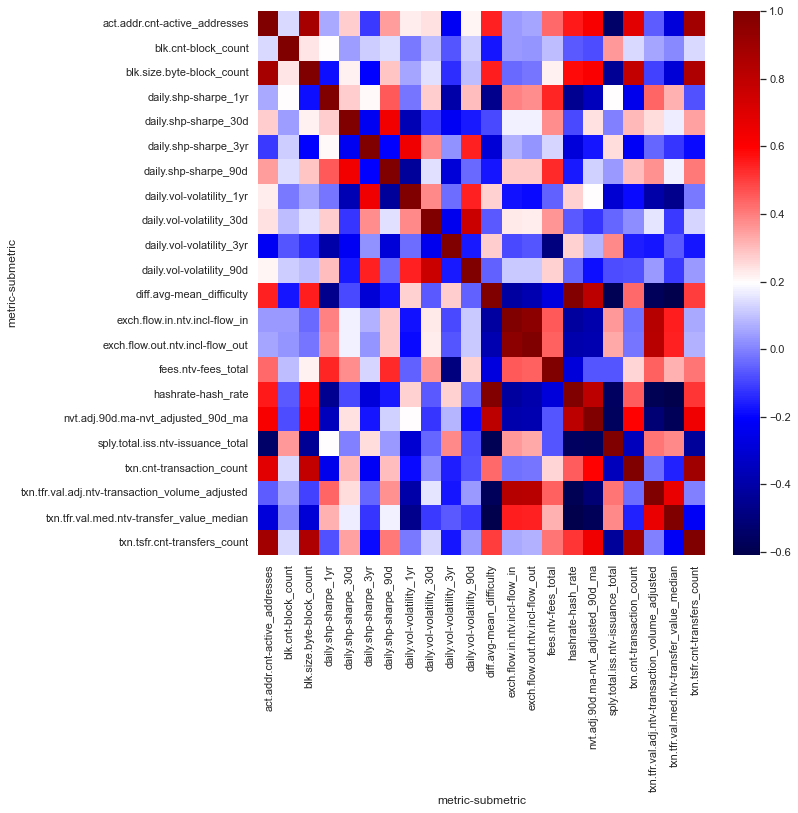

In [30]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(corr_data, cmap='seismic')

In [ ]:
n_features = train_df['metric'].nunique()
ax_index = np.arange(1, n_features)
metric_features = train_df['metric'].unique().tolist()
metric_features.remove('price')

fig, ax = plt.subplots(nrows=n_features, ncols=1, sharex=True)
prices_train['close'].plot(ax=ax[0], title='bitcoin.prices.usd')

for metric, num in zip(metric_features, ax_index):
    wide_train[metric].plot(
        ax=ax[num],
        figsize=(12, n_features*2.3),
        title=metric
    )

fig.suptitle('Time Series of Blockchain-derived Data', y=0.89)
fig.savefig('../raw/tsplot_train.png', dpi=300, bbox_inches='tight')

In [ ]:
n_features = test_df['metric'].nunique()
ax_index = np.arange(1, n_features)
metric_features = test_df['metric'].unique().tolist()
metric_features.remove('price')

fig, ax = plt.subplots(nrows=n_features, ncols=1, sharex=True)
prices_test['close'].plot(ax=ax[0], title='bitcoin.prices.usd')

for metric, num in zip(metric_features, ax_index):
    wide_test[metric].plot(
        ax=ax[num],
        figsize=(12, n_features*2.3),
        title=metric
    )

fig.suptitle('Time Series of Blockchain-derived Data', y=0.89)
fig.savefig('../raw/tsplot_test.png', dpi=300, bbox_inches='tight')

### Predictive Modeling

In [31]:
mainmodel = pipeline.ModelPipeline(ini_dir='../config/model.ini', section='BASEMODEL')

In [32]:
# xtrain, xtest = wide_train, wide_test
xtrain, xtest = mainmodel.transformer.normalize(wide_train, wide_test)

In [33]:
xtrain, ytrain = mainmodel.transformer.create_dataset(
    xtrain,
    prices_train['close'],
    return_train_y=True
)
xtest, ytest = mainmodel.transformer.create_dataset(
    xtest,
    prices_test['close']
)

In [34]:
# Load weights from previous run
mainmodel.reload()

In [35]:
mainmodel.model_train(xtrain, ytrain, xtest, ytest, verbose=0)

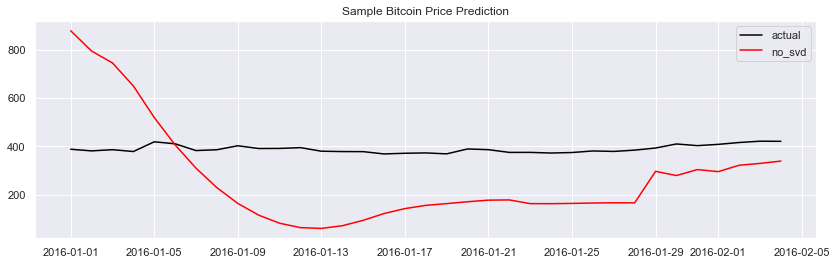

In [36]:
xvals = xtrain[15].values
xvals = xvals.reshape(1, xvals.shape[0], xvals.shape[1])
yactual = ytrain[15].values
ypred = mainmodel.tfmodel(xvals, training=True)
ypred = ypred.numpy()
ypred = ypred.reshape(ypred.shape[1])
xtime = pd.date_range(xtrain[0].index[0], periods=ypred.shape[0])

fig, ax = plt.subplots(figsize=(14,4))
ax.plot(xtime, yactual, linestyle='-', color='black', label='actual')
ax.plot(xtime, ypred, linestyle='-', color='red', label='no_svd')
ax.set_title('Sample Bitcoin Price Prediction')
ax.legend()

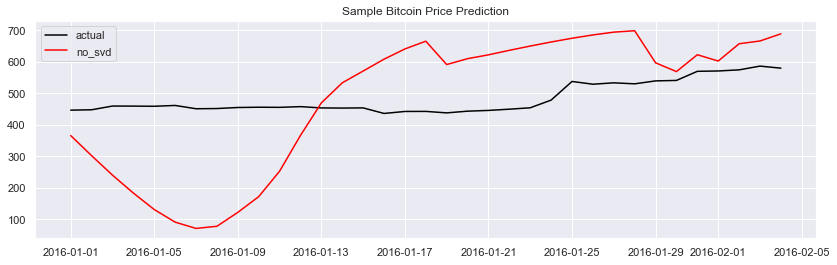

In [37]:
xvals = xtrain[124].values
xvals = xvals.reshape(1, xvals.shape[0], xvals.shape[1])
yactual = ytrain[124].values
ypred = mainmodel.tfmodel(xvals, training=True)
ypred = ypred.numpy()
ypred = ypred.reshape(ypred.shape[1])
xtime = pd.date_range(xtrain[0].index[0], periods=ypred.shape[0])

fig, ax = plt.subplots(figsize=(14,4))
ax.plot(xtime, yactual, linestyle='-', color='black', label='actual')
ax.plot(xtime, ypred, linestyle='-', color='red', label='no_svd')
ax.set_title('Sample Bitcoin Price Prediction')
ax.legend()

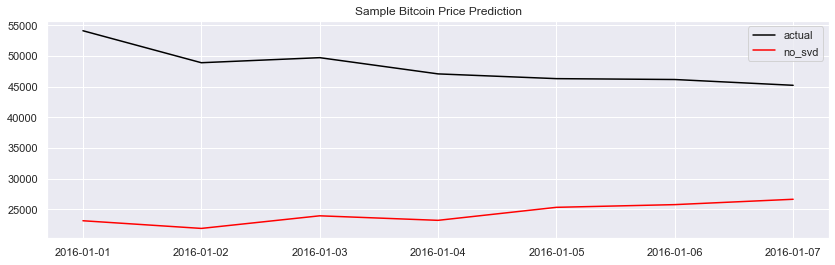

In [38]:
xvals = xtest[24].values
xvals = xvals.reshape(1, xvals.shape[0], xvals.shape[1])
yactual = ytest[24].values
ypred = mainmodel.tfmodel(xvals)
ypred = ypred.numpy()
ypred = ypred.reshape(ypred.shape[1])
xtime = pd.date_range(xtrain[0].index[0], periods=yactual.shape[0])
ytime = pd.date_range(xtime[-1], periods=ypred.shape[0])

fig, ax = plt.subplots(figsize=(14,4))
ax.plot(xtime, yactual, linestyle='-', color='black', label='actual')
ax.plot(xtime, ypred, linestyle='-', color='red', label='no_svd')
ax.set_title('Sample Bitcoin Price Prediction')
ax.legend()

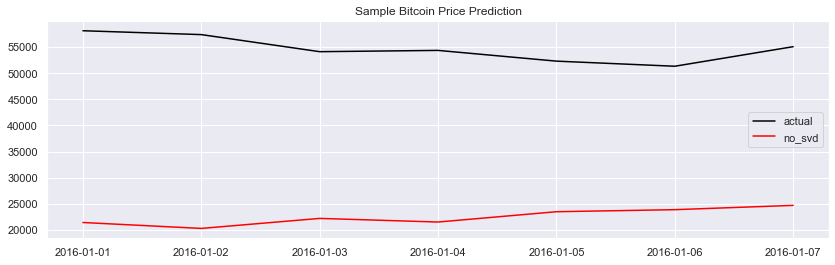

In [39]:
xvals = xtest[50].values
xvals = xvals.reshape(1, xvals.shape[0], xvals.shape[1])
yactual = ytest[50].values
ypred = mainmodel.tfmodel(xvals)
ypred = ypred.numpy()
ypred = ypred.reshape(ypred.shape[1])
xtime = pd.date_range(xtrain[0].index[0], periods=yactual.shape[0])
ytime = pd.date_range(xtime[-1], periods=ypred.shape[0])

fig, ax = plt.subplots(figsize=(14,4))
ax.plot(xtime, yactual, linestyle='-', color='black', label='actual')
ax.plot(xtime, ypred, linestyle='-', color='red', label='no_svd')
ax.set_title('Sample Bitcoin Price Prediction')
ax.legend()